<h1><center><font size="25">Functional testing skforecast</font></center></h1>

<center><b>Joaquín Amat Rodrigo</b></center>

<center><i>March, 2021</i></center>

This notebook performs functional testing for the library skforecast. For unit testing see folder *tests*.

In [1]:
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterCustom import ForecasterCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import time_series_spliter
from skforecast.model_selection import cv_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

## ForecasterAutoreg

### No exogenous predictor

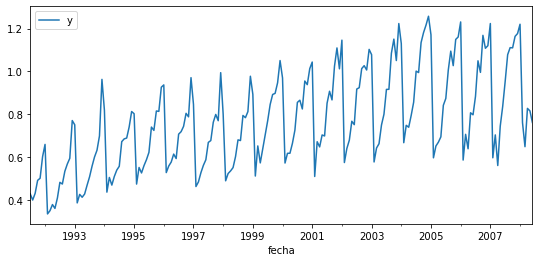

In [2]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
ax.legend();

In [3]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 15
                )

forecaster.fit(y=datos_train)
forecaster

=======================ForecasterAutoreg=======================
Regressor: LinearRegression()
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Exogenous variable: False
Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}

Test error (mse): 0.011051937043503738


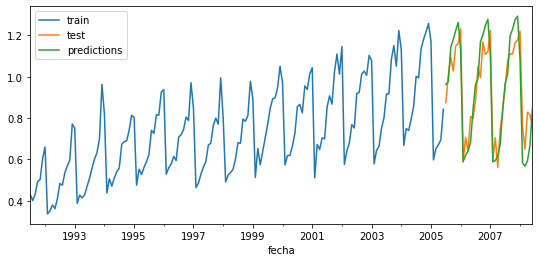

In [4]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps)
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

**Expected result:**

Test error (mse): 0.011051937043503738

In [6]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'neg_mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

loop lags_grid: 100%|██████████| 3/3 [00:14<00:00,  4.88s/it] 
2021-03-31 20:58:24,983 root       INFO  Refitting `forecaster` using the best found parameters: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.026520
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.026967
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.028092
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.028693
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.029500
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.033252
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.033828
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.034154
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.036539
3,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 100}",0.036623


**Expected result (non exact reproducibility):**

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]	{'max_depth': 10, 'n_estimators': 50}	0.026520  

In [7]:
# Predictors importance
# ==============================================================================
print(forecaster.get_feature_importances())

[0.58857871 0.10819445 0.06032462 0.02772937 0.02760762 0.01349508
 0.03496535 0.01883128 0.02761474 0.09265878]


**Expected result (non exact reproducibility)**

[0.58857871 0.10819445 0.06032462 0.02772937 0.02760762 0.01349508
 0.03496535 0.01883128 0.02761474 0.09265878]

In [8]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'neg_mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

loop lags_grid: 100%|██████████| 3/3 [00:06<00:00,  2.23s/it] 
2021-03-31 20:58:31,982 root       INFO  Refitting `forecaster` using the best found parameters: 
lags: [ 1  2  3 20] 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.050024
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.054322
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.056827
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.056929
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.057539
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.058406
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.058613
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.060764
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.061873
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.062285


**Expected result (non exact reproducibility)**

[1, 2, 3, 20]	{'max_depth': 10, 'n_estimators': 50}	0.057822

In [9]:
# Autorregresive lineal model statsmodels
# ==============================================================================
from statsmodels.tsa.ar_model import AutoReg
lags = 15

modelo_ar = AutoReg(datos_train, lags=lags)
res = modelo_ar.fit()
predicciones_statsmodels = res.predict(start=datos_test.index[0], end=datos_test.index[-1])

# Autorregresive lineal model Forecaster
# ==============================================================================
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=lags)
forecaster.fit(y=datos_train)
predicciones_forecaster = forecaster.predict(steps=36)

# Predictions from both models must be the equal
# ==============================================================================
print(np.allclose(predicciones_statsmodels.values, predicciones_forecaster))

# Coeficients from both models must be the equal
# ==============================================================================
print(np.allclose(res.params.values[1:], forecaster.get_coef()))

True
True


**Expected result:**

True

True

Number of observations used for training: 95
Number of folds: 4
Last fold only includes 1 observations.
[0.02150972]


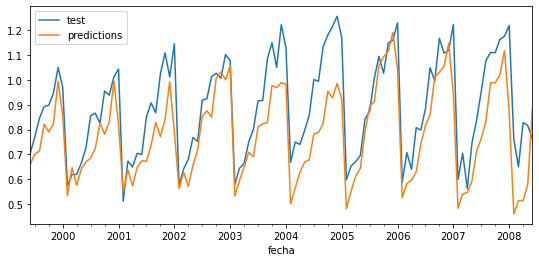

In [10]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=15)

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos,
    initial_train_size = len(datos_train),
    steps      = steps,
    metric     = 'neg_mean_squared_error',
    verbose    = True
)
print(metrica)

# Add datetime index to predictions
predicciones_backtest = pd.Series(data=predicciones_backtest, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predictions')
ax.legend();

**Expected result:**

Number of observations used for training: 95

Number of folds: 4

Last fold only includes 1 observations.

[0.02150972]

In [11]:
print(len(predicciones_backtest), predicciones_backtest)

109 fecha
1999-06-01    0.659751
1999-07-01    0.700833
1999-08-01    0.713227
1999-09-01    0.821183
1999-10-01    0.790163
                ...   
2008-02-01    0.459349
2008-03-01    0.513128
2008-04-01    0.513193
2008-05-01    0.578220
2008-06-01    0.888897
Freq: MS, Length: 109, dtype: float64


**Expected result:**
    
109 fecha
1999-06-01    0.659751
1999-07-01    0.700833
1999-08-01    0.713227
1999-09-01    0.821183
1999-10-01    0.790163
                ...   
2008-02-01    0.459349
2008-03-01    0.513128
2008-04-01    0.513193
2008-05-01    0.578220
2008-06-01    0.888897
Freq: MS, Length: 109, dtype: float64

In [12]:
# Check backtesting predictions
forecaster.fit(y=datos_train)
predictions_1 = forecaster.predict(steps=steps)
predictions_2 = forecaster.predict(steps=steps, last_window=datos_test[:steps])
predictions_3 = forecaster.predict(steps=steps, last_window=datos_test[steps:steps*2])
predictions_4 = forecaster.predict(steps=1, last_window=datos_test[steps*2:steps*3])
(predicciones_backtest == np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4])).all()

True

**Expected result:**
    
True

In [13]:
# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

Test error (mse): 0.011051937043503738


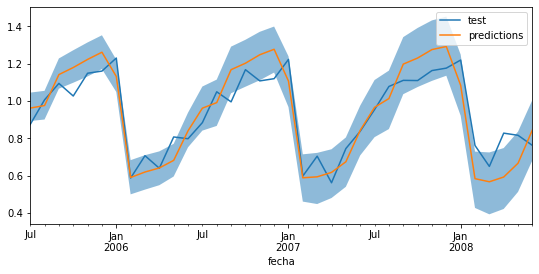

In [14]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor=LinearRegression(),
                    lags=15
                )

forecaster.fit(y=datos_train)

# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    interval = [5, 95],
                    n_boot   = 1000
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected result:**
    
Test error (mse): 0.011051937043503738

Number of observations used for training: 95
Number of folds: 4
Last fold only includes 1 observations.
[0.02150972]


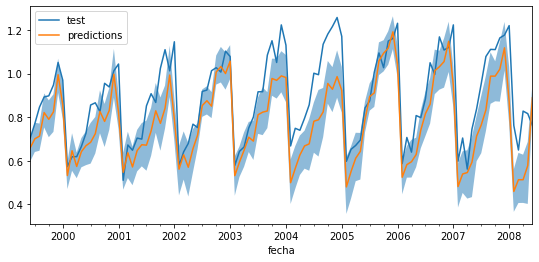

In [16]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=15)

metrica, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            metric     = 'neg_mean_squared_error',
                            interval            = [5, 95],
                            n_boot              = 100,
                            in_sample_residuals = True,
                            verbose             = True
                       )

print(metrica)

# Se añade el índice temporal a las predicciones
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected result:**
    
Number of observations used for training: 95
    
Number of folds: 4
    
Last fold only includes 1 observations.

[0.02150972]

### 1 exogenous predictor
<br>

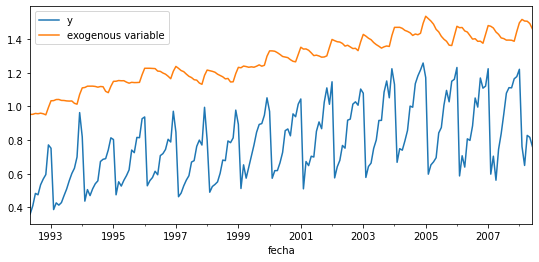

In [17]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variable
# ==============================================================================
datos_exog = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog = datos_exog[10:]
datos = datos[10:]

fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
datos_exog.plot(ax=ax, label='exogenous variable')
ax.legend();


# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog_train = datos_exog[:-steps]
datos_exog_test  = datos_exog[-steps:]

Test error (mse): 0.020306077140235405


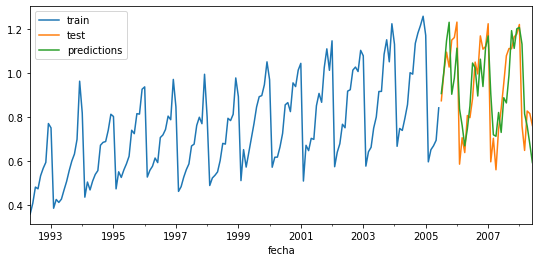

In [18]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 8
             )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=datos_exog_test)
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error prediction
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

**Expected result**

Test error (mse): 0.020306077140235405

In [19]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'neg_mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

loop lags_grid: 100%|██████████| 3/3 [00:12<00:00,  4.27s/it] 
2021-03-31 21:01:53,742 root       INFO  Refitting `forecaster` using the best found parameters: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.028383
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.028550
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.028952
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.030860
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.035755
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.037170
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.037354
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.039665
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.041344
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.044439


**Expected result (non exact reproducibility)**

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]	{'max_depth': 10, 'n_estimators': 50}	0.028383

In [20]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'neg_mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

loop lags_grid: 100%|██████████| 3/3 [00:06<00:00,  2.12s/it] 
2021-03-31 21:02:00,343 root       INFO  Refitting `forecaster` using the best found parameters: 
lags: [ 1  2  3 20] 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.054245
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.059871
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.062230
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.062298
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.062390
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.065474
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.065545
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.066951
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.071877
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.073482


**Expected result (non exact reproducibility)**

[1, 2, 3, 20]	{'max_depth': 10, 'n_estimators': 50}	0.054245

In [21]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

steps = 36
lags  = 15
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=lags)

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos,
    exog       = datos_exog,
    initial_train_size = len(datos_train),
    steps      = steps,
    metric     = 'neg_mean_squared_error',
    verbose    = True
)

print(metrica)

# Check backtesting predictions
forecaster.fit(y=datos_train, exog=datos_exog_train)
predictions_1 = forecaster.predict(steps=steps, exog=datos_exog_test[:steps])
predictions_2 = forecaster.predict(steps=steps, last_window=datos_test[:steps], exog=datos_exog_test[steps:steps*2])
predictions_3 = forecaster.predict(steps=steps, last_window=datos_test[steps:steps*2], exog=datos_exog_test[steps*2:steps*3])
predictions_4 = forecaster.predict(steps=1, last_window=datos_test[steps*2:steps*3], exog=datos_exog_test[steps*3:steps*4])
(predicciones_backtest == np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4])).all()

Number of observations used for training: 85
Number of folds: 4
Last fold only includes 1 observations.
[1.06455513e-29]


True

**Expected result**


Number of observations used for training: 85

Number of folds: 4

Last fold only includes 1 observations.

[1.06455513e-29]

True


In [22]:
# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog_train = datos_exog[:-steps]
datos_exog_test  = datos_exog[-steps:]

Test error (mse): 0.020306077140235405


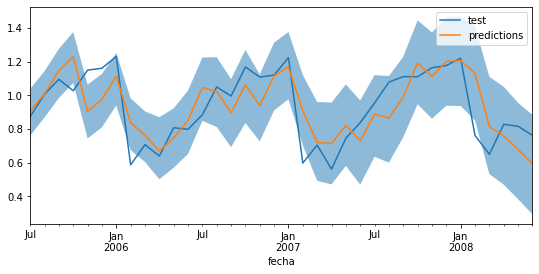

In [23]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 8
             )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    exog     = datos_exog_test,
                    interval = [5, 95],
                    n_boot   = 500
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected result**

Test error (mse): 0.020306077140235405

In [25]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=8)

metrica, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos,
                            exog       = datos_exog,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            metric     = 'neg_mean_squared_error',
                            interval            = [5, 95],
                            n_boot              = 100,
                            in_sample_residuals = True,
                            verbose             = True
                       )

print(metrica)

Number of observations used for training: 85
Number of folds: 4
Last fold only includes 1 observations.
[0.01325921]


**Expected values**

Number of observations used for training: 85
    
Number of folds: 4
    
Last fold only includes 1 observations.

[0.01325921]

### n exogenous predictors
<br>

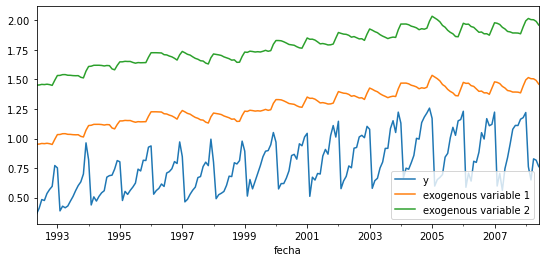

In [27]:
# Download data
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/' \
      + 'Estadistica-machine-learning-python/master/data/h2o.csv'
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variables
# ==============================================================================
datos_exog_1 = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog_2 = datos.rolling(window=10, closed='right').mean() + 1
datos_exog_1 = datos_exog_1[10:]
datos_exog_2 = datos_exog_2[10:]
datos = datos[10:]

fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
datos_exog_1.plot(ax=ax, label='exogenous variable 1')
datos_exog_2.plot(ax=ax, label='exogenous variable 2')
ax.legend();

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog = np.column_stack((datos_exog_1.values, datos_exog_2.values))
datos_exog_train = datos_exog[:-steps,]
datos_exog_test  = datos_exog[-steps:,]

Test error (mse): 0.02030607714023512


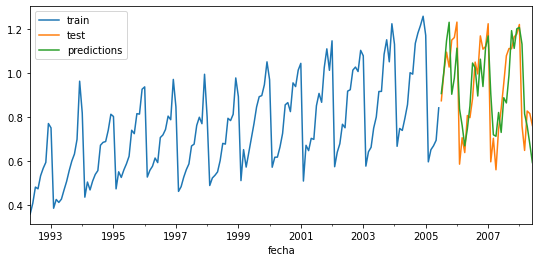

In [28]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 8
             )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=datos_exog_test)
# Add datetime index
predictions = pd.Series(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

**Expected result**

Test error (mse): 0.02030607714023512

In [29]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=RandomForestRegressor(random_state=123),
                lags=12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'neg_mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

loop lags_grid: 100%|██████████| 3/3 [00:12<00:00,  4.31s/it] 
2021-03-31 21:04:48,315 root       INFO  Refitting `forecaster` using the best found parameters: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'max_depth': 5, 'n_estimators': 50}



,lags,params,metric
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.025775
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.027541
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.028391
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.029196
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.036057
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.037904
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.039041
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.040024
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.042173
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.042883


**Expected result (non exact reproducibility)**

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]	{'max_depth': 5, 'n_estimators': 50}	0.025775

In [30]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=RandomForestRegressor(random_state=123),
                lags=12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'neg_mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

loop lags_grid: 100%|██████████| 3/3 [00:06<00:00,  2.14s/it] 
2021-03-31 21:04:54,988 root       INFO  Refitting `forecaster` using the best found parameters: 
lags: [ 1  2  3 20] 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.053074
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.058703
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.059072
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.059077
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.062055
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.062533
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.062782
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.066737
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.066839
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.067315


**Expected result (non exact reproducibility)**

[1, 2, 3, 20]	{'max_depth': 10, 'n_estimators': 50}	0.053074

In [31]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test,]
datos_exog_test  = datos_exog[-n_test:,]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=lags)

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos,
    exog       = datos_exog,
    initial_train_size = len(datos_train),
    steps      = steps,
    metric     = 'neg_mean_squared_error',
    verbose    = True
)
print(metrica)

# Check backtesting predictions
forecaster.fit(y=datos_train, exog=datos_exog_train)
predictions_1 = forecaster.predict(steps=steps, exog=datos_exog_test[:steps,])
predictions_2 = forecaster.predict(steps=steps, last_window=datos_test[:steps], exog=datos_exog_test[steps:steps*2,])
predictions_3 = forecaster.predict(steps=steps, last_window=datos_test[steps:steps*2], exog=datos_exog_test[steps*2:steps*3,])
predictions_4 = forecaster.predict(steps=1, last_window=datos_test[steps*2:steps*3], exog=datos_exog_test[steps*3:steps*4,])
(predicciones_backtest == np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4])).all()

Number of observations used for training: 85
Number of folds: 4
Last fold only includes 1 observations.
[7.69456013e-30]


True

**Expected result**

Number of observations used for training: 85
    
Number of folds: 4
    
Last fold only includes 1 observations.

[7.69456013e-30]

True

In [32]:
# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog = np.column_stack((datos_exog_1.values, datos_exog_2.values))
datos_exog_train = datos_exog[:-steps,]
datos_exog_test  = datos_exog[-steps:,]

Test error (mse): 0.02030607714023512


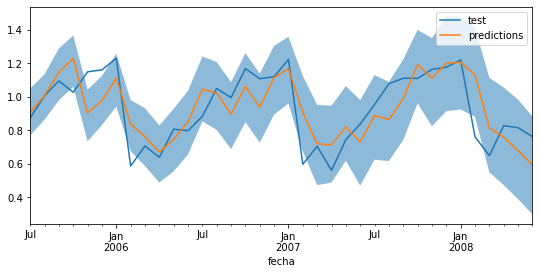

In [33]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 8
             )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    exog     = datos_exog_test,
                    interval = [5, 95],
                    n_boot   = 500
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected value**

Test error (mse): 0.02030607714023512

In [35]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=8)

metrica, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos,
                            exog       = datos_exog,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            metric     = 'neg_mean_squared_error',
                            interval            = [5, 95],
                            n_boot              = 100,
                            in_sample_residuals = True,
                            verbose             = True
                       )

print(metrica)

Number of observations used for training: 85
Number of folds: 4
Last fold only includes 1 observations.
[0.01325921]


**Expected value**

Number of observations used for training: 85
    
Number of folds: 4
    
Last fold only includes 1 observations.

[0.01325921]

## ForecasterCustom

### No exogenous predictor

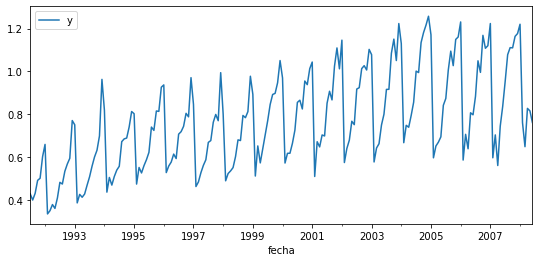

In [3]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
ax.legend();

In [4]:
# Custom function to create poredictors
# ==============================================================================
def create_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    X_train = pd.DataFrame({'y':y.copy()})
    for i in range(0, 10):
        X_train[f'lag_{i+1}'] = X_train['y'].shift(i)
        
    X_train['moving_avg'] = X_train['y'].rolling(20).mean()
    
    X_train = X_train.drop(columns='y').tail(1).to_numpy()  
    
    return X_train  

In [6]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

forecaster.fit(y=datos_train)
forecaster

=======================ForecasterCustom=======================
Regressor: LinearRegression()
Predictors created with: create_predictors
Window size: 20
Exogenous variable: False
Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}

Test error (mse): 0.024334075665271356


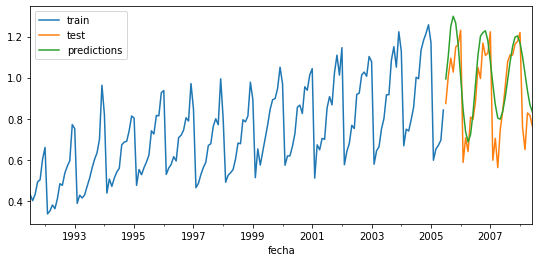

In [7]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

**Expected result**

Test error (mse): 0.024334075

In [54]:
# Grid search hiperparameters
# ==============================================================================
forecaster = ForecasterCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}


results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        steps       = 36,
                        metric      = 'neg_mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

loop lags_grid: 100%|██████████| 1/1 [00:07<00:00,  7.93s/it] 
2021-03-31 21:14:33,289 root       INFO  Refitting `forecaster` using the best found parameters: 
lags: custom predictors 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.021727
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.022134
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.028108
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.032680


**Expected result (non exact reproducibility)**

custom predictors	{'max_depth': 10, 'n_estimators': 50}	0.021727

In [55]:
# Grid search hiperparameters
# ==============================================================================
forecaster = ForecasterCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}


results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        steps       = 36,
                        metric      = 'neg_mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

loop lags_grid: 100%|██████████| 1/1 [00:05<00:00,  5.80s/it] 
2021-03-31 21:14:40,225 root       INFO  Refitting `forecaster` using the best found parameters: 
lags: custom predictors 
params: {'max_depth': 5, 'n_estimators': 100}



,lags,params,metric
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.058251
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.059011
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.061352
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.063328


**Expected result (non exact reproducibility)**

custom predictors	{'max_depth': 5, 'n_estimators': 100}	0.058251

In [56]:
# Predictors importance
# ==============================================================================
print(forecaster.get_feature_importances())

[0.57297604 0.10797729 0.04122921 0.01996422 0.02964171 0.00950612
 0.04090579 0.0101996  0.01486522 0.11273685 0.03999795]


**Expected result (non exact reproducibility)**

[0.57297604 0.10797729 0.04122921 0.01996422 0.02964171 0.00950612
 0.04090579 0.0101996  0.01486522 0.11273685 0.03999795]

In [57]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]

steps = 36
forecaster = ForecasterCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos,
    initial_train_size = len(datos_train),
    steps      = steps,
    metric     = 'neg_mean_squared_error',
    verbose    = True
)

print(metrica)

# Check backtesting predictions
forecaster.fit(y=datos_train)
predictions_1 = forecaster.predict(steps=steps)
predictions_2 = forecaster.predict(steps=steps, last_window=datos_test[:steps])
predictions_3 = forecaster.predict(steps=steps, last_window=datos_test[steps:steps*2])
predictions_4 = forecaster.predict(steps=1, last_window=datos_test[steps*2:steps*3])
(predicciones_backtest == np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4])).all()

Number of observations used for training: 95
Number of folds: 4
Last fold only includes 1 observations.
[0.07797512]


True

**Expected result**

Number of observations used for training: 95
    
Number of folds: 4
    
Last fold only includes 1 observations.

[0.07797512]

True

In [58]:
# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

Test error (mse): 0.024334075665271356


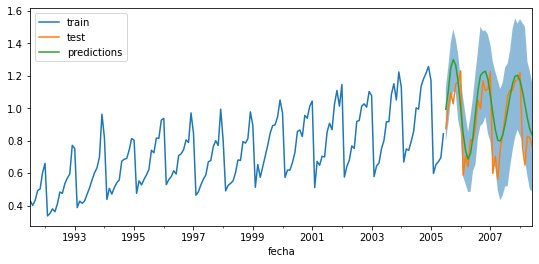

In [66]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

forecaster.fit(y=datos_train)

# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    interval = [5, 95],
                    n_boot   = 100
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected result:**
    
Test error (mse): 0.024334075665271356

Number of observations used for training: 95
Number of folds: 4
Last fold only includes 1 observations.
[0.06468538]


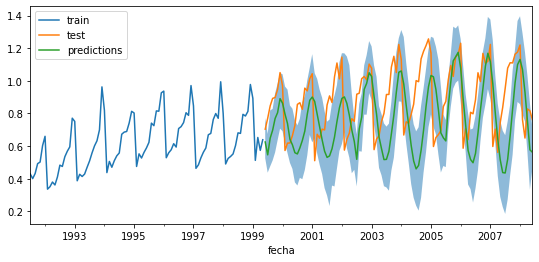

In [68]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

metrica, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            metric     = 'neg_mean_squared_error',
                            interval            = [5, 95],
                            n_boot              = 100,
                            in_sample_residuals = True,
                            verbose             = True
                       )

print(metrica)

**Expected result:**
    
Number of observations used for training: 95
    
Number of folds: 4
    
Last fold only includes 1 observations.

[0.06468538]

### 1 exogenous predictor
<br>

In [69]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variable
# ==============================================================================
datos_exog = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog = datos_exog[10:]
datos = datos[10:]

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog_train = datos_exog[:-steps]
datos_exog_test  = datos_exog[-steps:]

Test error (mse): 1.1605225860445398e-29


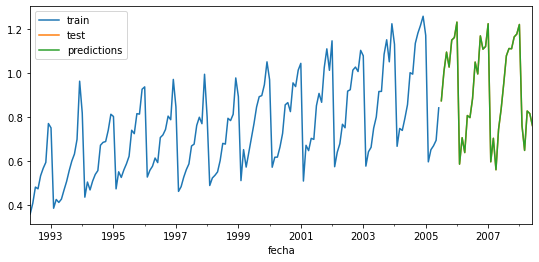

In [70]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=datos_exog_test)
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error prediction
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

**Expected result**

Test error (mse): 1.1605225860445398e-29

In [71]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        steps       = 10,
                        metric      = 'neg_mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

loop lags_grid: 100%|██████████| 1/1 [00:20<00:00, 21.00s/it] 
2021-03-31 21:26:41,585 root       INFO  Refitting `forecaster` using the best found parameters: 
lags: custom predictors 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.021906
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.021939
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.022061
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.022717


**Expected result (non exact reproducibility)**

custom predictors	{'max_depth': 10, 'n_estimators': 50}	0.021906


In [72]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        steps       = 10,
                        metric      = 'neg_mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

loop lags_grid: 100%|██████████| 1/1 [00:05<00:00,  5.44s/it] 
2021-03-31 21:26:48,074 root       INFO  Refitting `forecaster` using the best found parameters: 
lags: custom predictors 
params: {'max_depth': 5, 'n_estimators': 50}



,lags,params,metric
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.070085
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.070108
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.072824
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.074346


**Expected result (non exact reproducibility)**

custom predictors	{'max_depth': 5, 'n_estimators': 50}	0.070085

In [73]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterCustom(
                    regressor      = regressor,
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos,
    exog       = datos_exog,
    initial_train_size = len(datos_train),
    steps      = steps,
    metric     = 'neg_mean_squared_error'
)

print(metrica)

# Check backtesting predictions
forecaster.fit(y=datos_train, exog=datos_exog_train)
predictions_1 = forecaster.predict(steps=steps, exog=datos_exog_test[:steps])
predictions_2 = forecaster.predict(steps=steps, last_window=datos_test[:steps], exog=datos_exog_test[steps:steps*2])
predictions_3 = forecaster.predict(steps=steps, last_window=datos_test[steps:steps*2], exog=datos_exog_test[steps*2:steps*3])
predictions_4 = forecaster.predict(steps=1, last_window=datos_test[steps*2:steps*3], exog=datos_exog_test[steps*3:steps*4])
(predicciones_backtest == np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4])).all()

[1.76258847e-29]


True

**Expected result**

Number of observations used for training: 85

Number of folds: 4

Last fold only includes 1 observations.

[1.76258847e-29]

True

In [78]:
# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog_train = datos_exog[:-steps]
datos_exog_test  = datos_exog[-steps:]

Test error (mse): 1.1605225860445398e-29


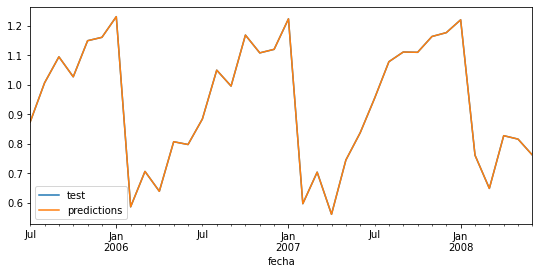

In [79]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    exog     = datos_exog_test,
                    interval = [5, 95],
                    n_boot   = 500
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected result**

Test error (mse): 0.020306077140235405

In [80]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

steps = 36
forecaster = ForecasterCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

metrica, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos,
                            exog       = datos_exog,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            metric     = 'neg_mean_squared_error',
                            interval            = [5, 95],
                            n_boot              = 100,
                            in_sample_residuals = True,
                            verbose             = True
                       )

print(metrica)

Number of observations used for training: 85
Number of folds: 4
Last fold only includes 1 observations.
[1.76258847e-29]


**Expected values**

Number of observations used for training: 85
    
Number of folds: 4
    
Last fold only includes 1 observations.

[0.01325921]

### n exogenous predictors
<br>

In [70]:
# Download data
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/' \
      + 'Estadistica-machine-learning-python/master/data/h2o.csv'
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variables
# ==============================================================================
datos_exog_1 = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog_2 = datos.rolling(window=10, closed='right').mean() + 1
datos_exog_1 = datos_exog_1[10:]
datos_exog_2 = datos_exog_2[10:]
datos = datos[10:]

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog = np.column_stack((datos_exog_1.values, datos_exog_2.values))
datos_exog_train = datos_exog[:-steps,]
datos_exog_test  = datos_exog[-steps:,]

Test error (mse): 1.5458246442999685e-27


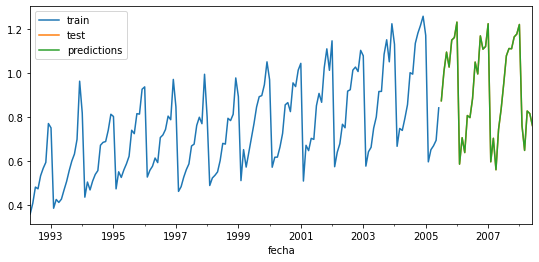

In [71]:
# Create and fit forecaster
# ==============================================================================
regressor = LinearRegression()
forecaster = ForecasterCustom(
                    regressor      = regressor,
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=datos_exog_test)
# Add datetime index
predictions = pd.Series(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

**Expected result**

Test error (mse): 1.5458246442999685e-27

In [73]:
# Grid search hiperparameters and lags
# ==============================================================================
regressor = RandomForestRegressor(random_state=123)
forecaster = ForecasterCustom(
                    regressor      = regressor,
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        steps       = 10,
                        metric      = 'neg_mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

loop lags_grid: 100%|██████████| 1/1 [00:21<00:00, 21.58s/it] 
2021-03-31 20:11:21,685 root       INFO  Refitting `forecaster` using the best found parameters: 
lags: custom predictors 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.021558
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.022205
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.023059
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.023823


**Expected result (non exact reproducibility)**

custom predictors	{'max_depth': 10, 'n_estimators': 50}	0.021558

In [74]:
# Grid search hiperparameters and lags
# ==============================================================================
regressor = RandomForestRegressor(random_state=123)
forecaster = ForecasterCustom(
                    regressor      = regressor,
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        steps       = 10,
                        metric      = 'neg_mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

loop lags_grid: 100%|██████████| 1/1 [00:05<00:00,  5.35s/it] 
2021-03-31 20:11:38,897 root       INFO  Refitting `forecaster` using the best found parameters: 
lags: custom predictors 
params: {'max_depth': 5, 'n_estimators': 100}



,lags,params,metric
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.069328
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.071051
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.072586
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.075003


**Expected result (non exact reproducibility)**

custom predictors	{'max_depth': 5, 'n_estimators': 100}	0.069328

In [75]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test,]
datos_exog_test  = datos_exog[-n_test:,]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterCustom(
                    regressor      = regressor,
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos,
    exog       = datos_exog,
    initial_train_size = len(datos_train),
    steps      = steps,
    metric     = 'neg_mean_squared_error'
)

print(metrica)

# Check backtesting predictions
forecaster.fit(y=datos_train, exog=datos_exog_train)
predictions_1 = forecaster.predict(steps=steps, exog=datos_exog_test[:steps,])
predictions_2 = forecaster.predict(steps=steps, last_window=datos_test[:steps], exog=datos_exog_test[steps:steps*2,])
predictions_3 = forecaster.predict(steps=steps, last_window=datos_test[steps:steps*2], exog=datos_exog_test[steps*2:steps*3,])
predictions_4 = forecaster.predict(steps=1, last_window=datos_test[steps*2:steps*3], exog=datos_exog_test[steps*3:steps*4,])
(predicciones_backtest == np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4])).all()

Number of observations used for training: 85
Number of folds: 4
Last fold only includes 1 observations.
[8.75843676e-30]


True

**Expected result**

Number of observations used for training: 85

Number of folds: 4

Last fold only includes 1 observations.

[8.75843676e-30]

True

## ForecasterAutoregMultiOutput

### No exogenous predictor

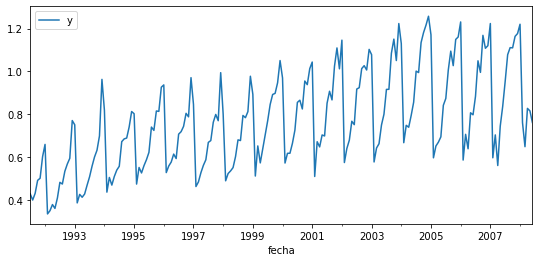

In [8]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
ax.legend();

In [9]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(random_state=123),
                    steps     = 36,
                    lags      = 15
                )

forecaster.fit(y=datos_train)
forecaster

forecaster

============================ForecasterAutoregMultiOutput============================
Regressor: MultiOutputRegressor(estimator=RandomForestRegressor(random_state=123))
Steps: 36
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Exogenous variable: False
Parameters: {'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'mse', 'estimator__max_depth': None, 'estimator__max_features': 'auto', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_impurity_split': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': 123, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestRegressor(random_state=123), 'n_jobs': None}

Test error (mse): 0.005334900471852241


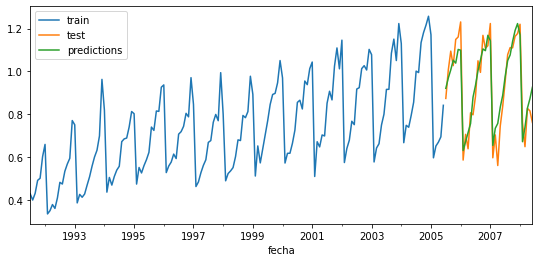

In [10]:
# Predict
# ==============================================================================
predictions = forecaster.predict()
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

**Expected result**

Test error (mse): 0.005334900471852241

In [11]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(random_state=123),
                    steps     = 36,
                    lags      = 3
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = forecaster.steps,
                        metric      = 'neg_mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

loop lags_grid: 100%|██████████| 3/3 [01:17<00:00, 25.91s/it] 
2021-03-31 22:06:04,652 root       INFO  Refitting `forecaster` using the best found parameters: 
lags: 3 
params: {'estimator__max_depth': 5, 'estimator__n_estimators': 100}



,lags,params,metric
1,3,"{'estimator__max_depth': 5, 'estimator__n_esti...",0.067066
5,10,"{'estimator__max_depth': 5, 'estimator__n_esti...",0.067066
9,"[1, 2, 3, 20]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.067066
0,3,"{'estimator__max_depth': 5, 'estimator__n_esti...",0.067744
4,10,"{'estimator__max_depth': 5, 'estimator__n_esti...",0.067744
8,"[1, 2, 3, 20]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.067744
3,3,"{'estimator__max_depth': 10, 'estimator__n_est...",0.067988
7,10,"{'estimator__max_depth': 10, 'estimator__n_est...",0.067988
11,"[1, 2, 3, 20]","{'estimator__max_depth': 10, 'estimator__n_est...",0.067988
2,3,"{'estimator__max_depth': 10, 'estimator__n_est...",0.068535


**Expected result (non exact reproducibility)**

10	{'estimator__max_depth': 5, 'estimator__n_esti...	0.067066

In [13]:
# Backtest 
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]

forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(random_state=123),
                    steps     = 36,
                    lags      = 15
             )

metrica, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos,
                            initial_train_size = len(datos_train),
                            steps      = forecaster.steps,
                            metric     = 'neg_mean_squared_error',
                            verbose    = True
                       )

print(metrica)

Number of observations used for training: 95
Number of folds: 4
Last fold only includes 1 observations.
[0.03719876]


**Expected result**

Number of observations used for training: 95
    
Number of folds: 4
    
Last fold only includes 1 observations.

[0.03719876]

## Session information

In [24]:
from sinfo import sinfo
sinfo()

-----
matplotlib  3.3.2
numpy       1.19.5
pandas      1.2.3
sinfo       0.3.1
skforecast  0.1.7
sklearn     0.24.1
statsmodels 0.11.1
tqdm        4.59.0
-----
IPython             7.20.0
jupyter_client      6.1.11
jupyter_core        4.7.1
notebook            6.2.0
-----
Python 3.7.9 (default, Aug 31 2020, 12:42:55) [GCC 7.3.0]
Linux-5.4.0-1041-aws-x86_64-with-debian-buster-sid
2 logical CPU cores, x86_64
-----
Session information updated at 2021-03-31 15:03


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by  Joaquín Amat Rodrigo is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.